In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
from livelossplot import PlotLosses
import torch as ch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import copy
import seaborn as sns
from matplotlib.animation import FuncAnimation

from mib.train import get_loader, get_model, get_data, evaluate_model
from scipy import stats
from sklearn.metrics import auc, roc_curve

from mib.attacks.theory import compute_trace

import matplotlib as mpl
import matplotlib.animation as animation


mpl.rcParams["figure.dpi"] = 300

In [2]:
# CIFAR
num_train_points = 25000
num_pop_points = 25000  # 10000
batch_size = 256
learning_rate = 0.1
weight_decay = 5e-4
epochs = 100

dataset = "CIFAR10"
device = "cuda"
criterion = nn.CrossEntropyLoss()

In [3]:
# Use same subset of data across all experiments
train_index, test_index, train_data, test_data = get_data(num_experiments=2, pkeep=0.5, exp_id=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
@ch.no_grad()
def collect_loss_values(model, loader, label_smoothing: float = 0.0):
    criterion_each = nn.CrossEntropyLoss(reduction='none', label_smoothing=label_smoothing)
    # Set model to eval model
    model.eval()
    
    all_losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x).detach()
        losses = criterion_each(y_hat, y)
        all_losses.append(losses.cpu())
    return ch.cat(all_losses)

In [7]:
def model_training_trial(num_retain: int = 1):
    # Get loaders (use same ordering of data across model inits)
    train_loader = get_loader(train_data, train_index, batch_size, start_seed=2024)
    test_loader = get_loader(test_data, test_index, batch_size, start_seed=2024)

    model, criterion, _ = get_model("wide_resnet_28_2", n_classes=10)

    # Set the loss function and optimizer
    optimizer = ch.optim.SGD(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9
    )
    scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    groups = {
        "acc": ["acc", "val_acc"],
        "Trace": ["Trace"],
        "loss": ["loss", "val_loss"],
        "m1": ["m1"],
        "m2": ["m2"],
        "lr": ["lr"]
    }
    plotter = PlotLosses(groups=groups)
    track_losses, track_models = [], []

    # Loop over each epoch
    trace_values, losses, accuracies = [], [], []
    m1_vals, m2_vals = [], []
    mem_losses, nonmem_losses = [], []
    learning_rates = []
    for epoch_idx in range(epochs):
        model.to(device)
        train_loss = 0
        train_acc = 0
        samples_seen = 0

        # Loop over the training set
        for data, target in train_loader:
            # Make sure model is in train mode
            model.train()

            # Move data to the device
            data_use = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            samples_seen += len(target)

            # Set the gradients to zero
            optimizer.zero_grad(set_to_none=True)

            # Get the model output
            output = model(data_use)

            # Calculate the loss
            binary_case = False
            if output.shape[1] == 1:
                # BCE loss case
                binary_case = True
                loss = criterion(output.squeeze(), target.float())
            else:
                # CE loss case
                loss = criterion(output, target.long())

            # Perform the backward pass
            loss.backward()

            # Take a step using optimizer
            optimizer.step()

            # Add the loss to the total loss
            train_loss += loss.detach().cpu().item()

            # Computing accuracy
            with ch.no_grad():
                if binary_case:
                    pred = output.data.squeeze() > 0.5
                    train_acc += pred.eq(target.data.view_as(pred)).sum().cpu().item()
                else:
                    pred = output.data.max(1, keepdim=True)[1]
                    train_acc += pred.eq(target.data.view_as(pred)).sum().cpu().item()
            
            # Scheduler step
            scheduler.step()

        # Compute mean gradients on population data
        trace_value, m1, m2 = compute_trace(model, train_loader, test_loader, device="cuda", shift_model=False, get_m1_m2=True)
        
        # Scale trace_value by 2 / learning-rate, if learning-rate is non-zero!
        lr = scheduler.get_lr()[0]
        if lr != 0:
            trace_value *= (2 / lr)

            # Save iter-wise values
            trace_values.append(trace_value)
            losses.append(loss.cpu().item())
            accuracies.append(100 * train_acc / samples_seen)
            m1_vals.append(m1.cpu().numpy())
            m2_vals.append(m2.cpu().numpy())
            learning_rates.append(lr)

        # Also keep track of validation loss, acc
        test_acc, test_loss = evaluate_model(model, test_loader, criterion, device=device)
        
        # Keep track of these test losses and also model states
        # At the end, we will retain the N-best model checkpoints
        track_losses.append(test_loss)
        track_models.append(copy.deepcopy(model.cpu()))

        # Plot on livelossplot
        plotter.update(
            {
                "loss": loss.cpu().item(),
                "acc": 100 * train_acc / samples_seen,
                "val_acc": 100 * test_acc,
                "val_loss": test_loss,
                "Trace": trace_value.item(),
                "m1": np.mean(m1.cpu().numpy()),
                "m2": np.mean(m2.cpu().numpy()),
                "lr": lr
            }
        )
        plotter.send()

        print(f"Epoch: {epoch_idx+1}/{epochs}")
    
    # checkpoints_wanted = np.argsort(track_losses)[:num_retain]
    # models_wanted = [track_models[i] for i in checkpoints_wanted]

    # return models_wanted, trace_values, losses, accuracies, mem_losses, nonmem_losses, m1_vals, m2_vals
    return model, trace_values, losses, accuracies, learning_rates, m1_vals, m2_vals

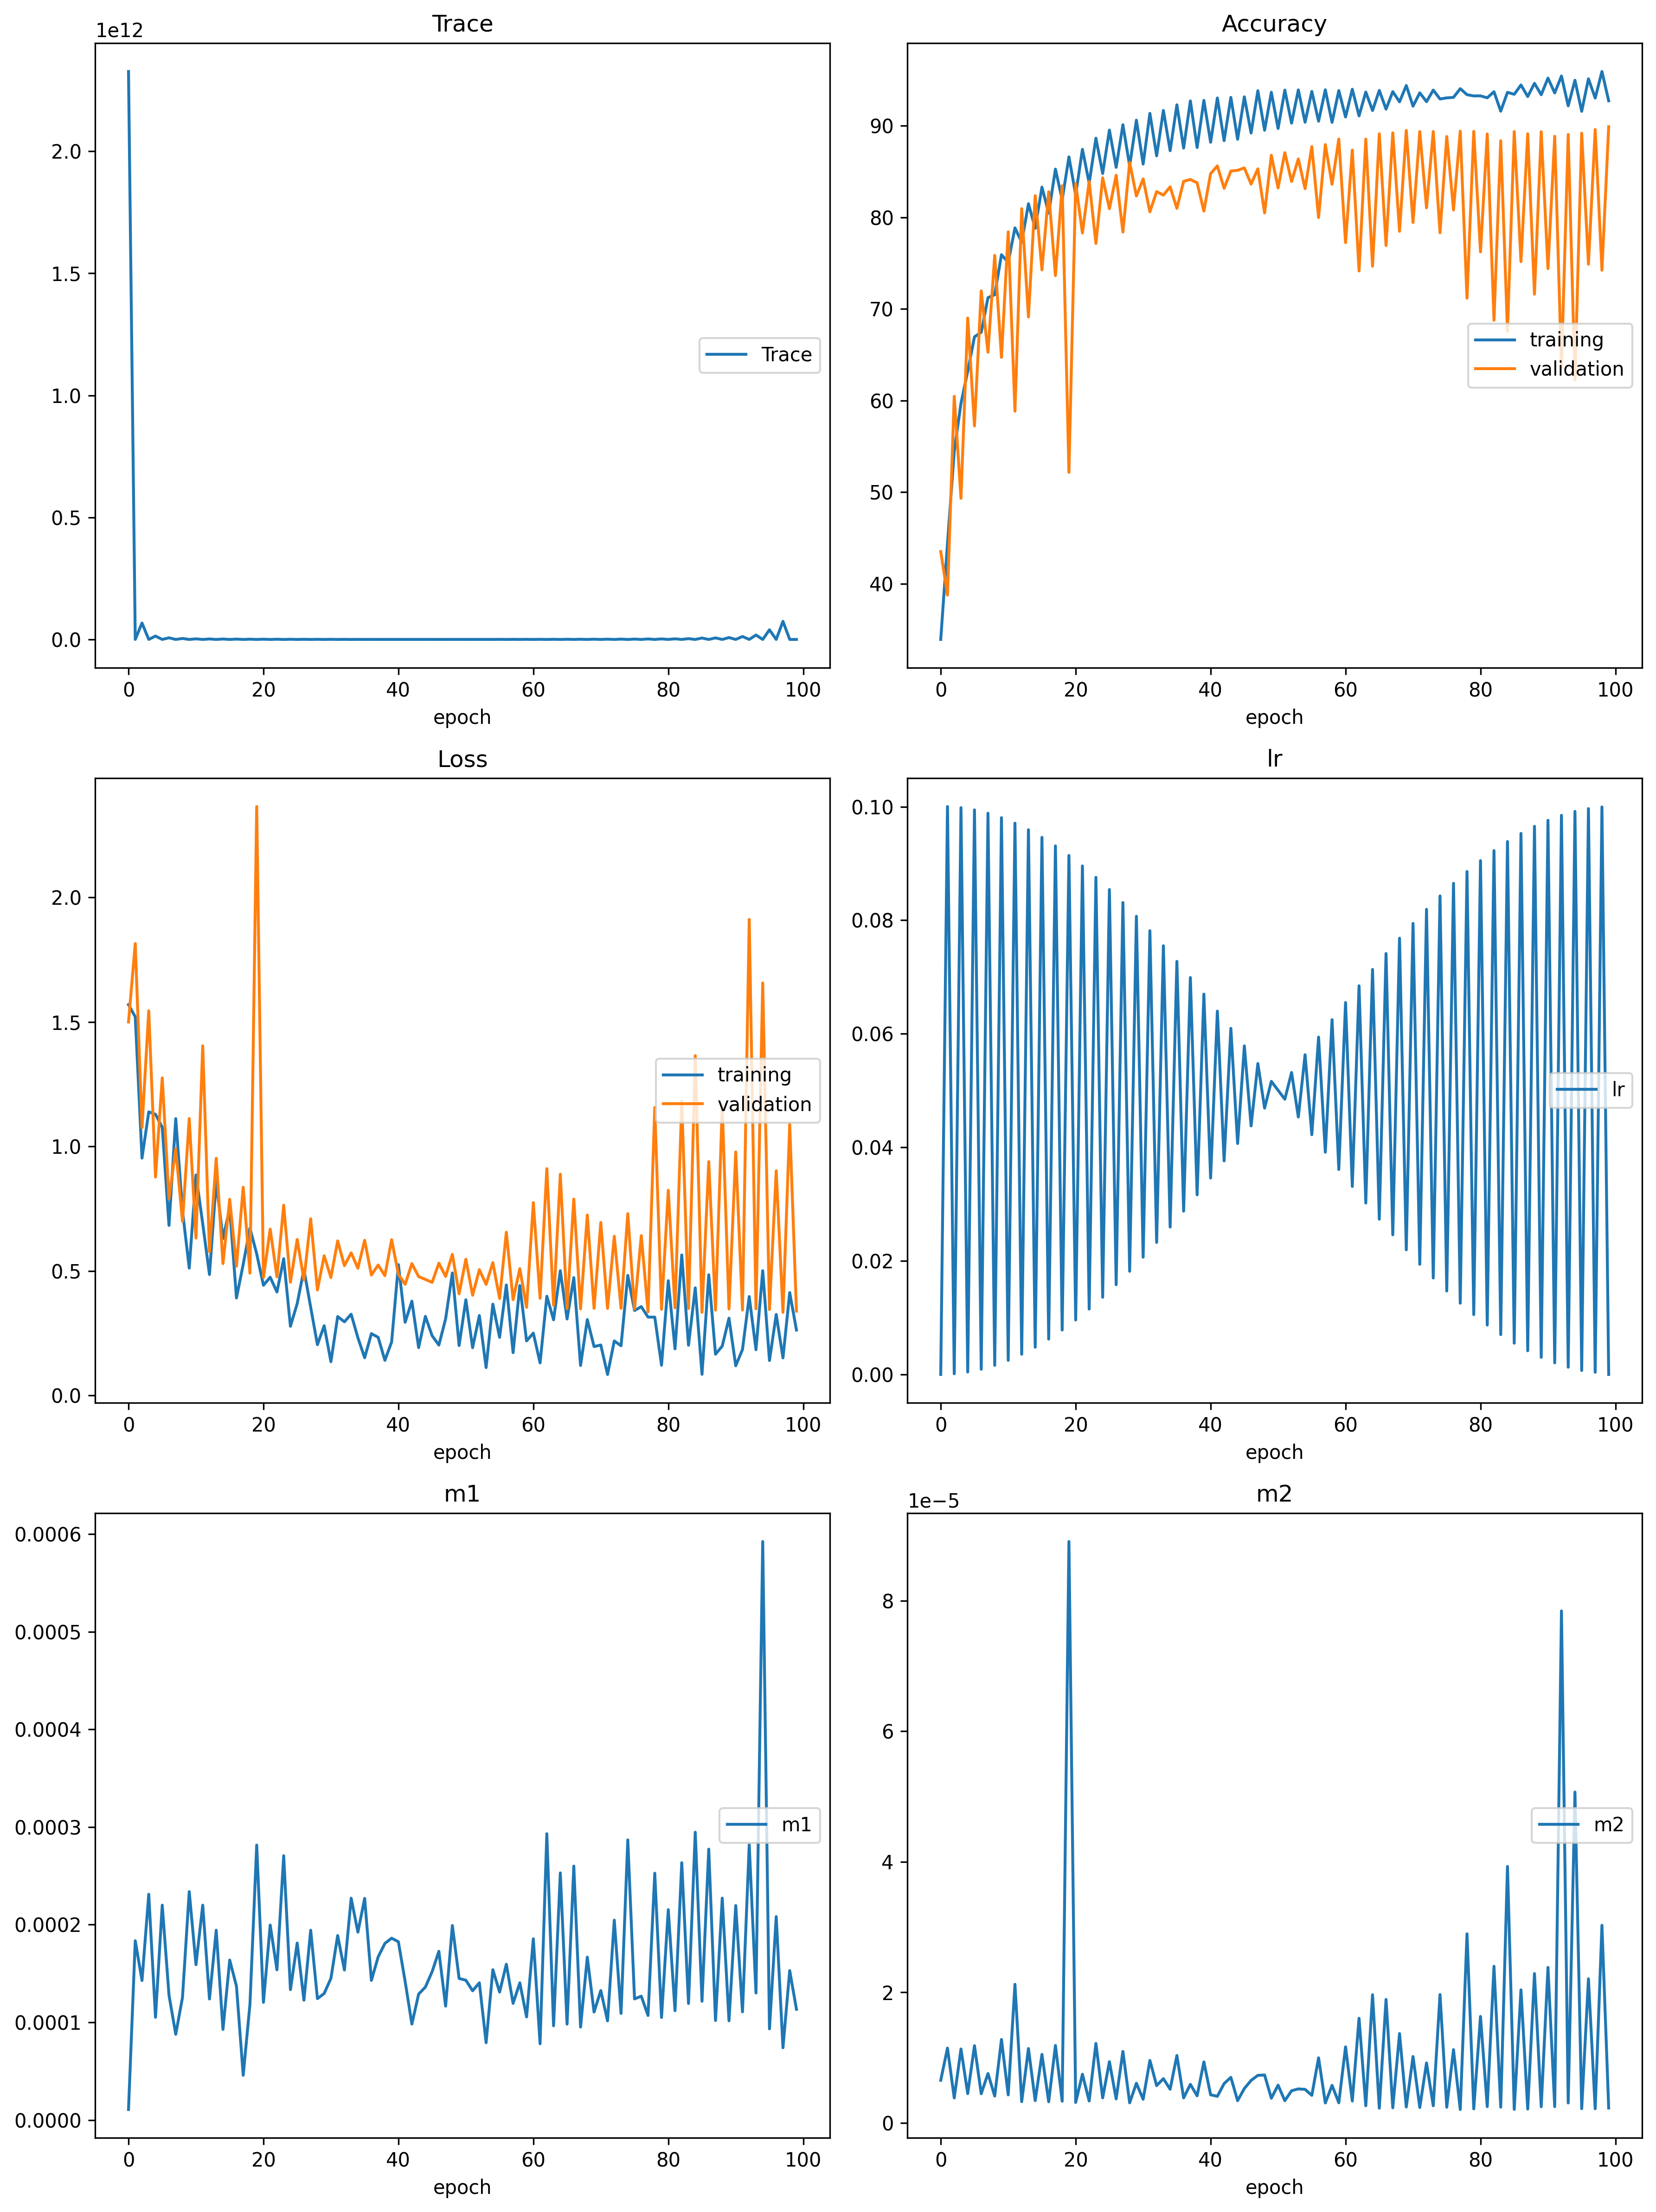

Trace
	Trace            	 (min: 14199421.000, max: 2326644916224.000, cur: 14199421.000)
Accuracy
	training         	 (min:   33.902, max:   95.919, cur:   92.722)
	validation       	 (min:   38.744, max:   89.888, cur:   89.888)
Loss
	training         	 (min:    0.084, max:    1.569, cur:    0.263)
	validation       	 (min:    0.334, max:    2.365, cur:    0.339)
lr
	lr               	 (min:    0.000, max:    0.100, cur:    0.000)
m1
	m1               	 (min:    0.000, max:    0.001, cur:    0.000)
m2
	m2               	 (min:    0.000, max:    0.000, cur:    0.000)
Epoch: 100/100


In [8]:
trace_values, models, m1_vals, m2_vals, lrs = [], [], [], [], []

n_trials = 5
for _ in range(n_trials):
    returned_values = model_training_trial(5)
    models.append(returned_values[0])
    trace_values.append(returned_values[1])
    lrs.append(returned_values[-3])
    m1_vals.append(returned_values[-2])
    m2_vals.append(returned_values[-1])

Visualize evolution of m1 and m2 as heatmap image, where ordering of parameters is based on values at convergence (only for nice visualization - no other purpose)

In [46]:
trace_values = np.array(trace_values)
m1_vals = np.array(m1_vals)
m2_vals = np.array(m2_vals)

In [124]:
idx = [0, 1, 3, 4]
trace_values_use = trace_values[idx]
m1_vals_use = m1_vals[idx]
m2_vals_use = m2_vals[idx]

In [137]:
traces = []
for i, m in enumerate(models):
    train_loader = get_loader(train_data, train_index, batch_size, start_seed=2024)
    test_loader = get_loader(test_data, test_index, batch_size, start_seed=2024)
    tr = compute_trace(m.cuda(), train_loader, test_loader, device="cuda", shift_model=False)
    m.cpu()
    traces.append(tr)
traces = np.array(traces)

In [140]:
traces[idx] / np.max(traces[idx])

array([0.8767955 , 0.9231645 , 1.        , 0.94970506], dtype=float32)

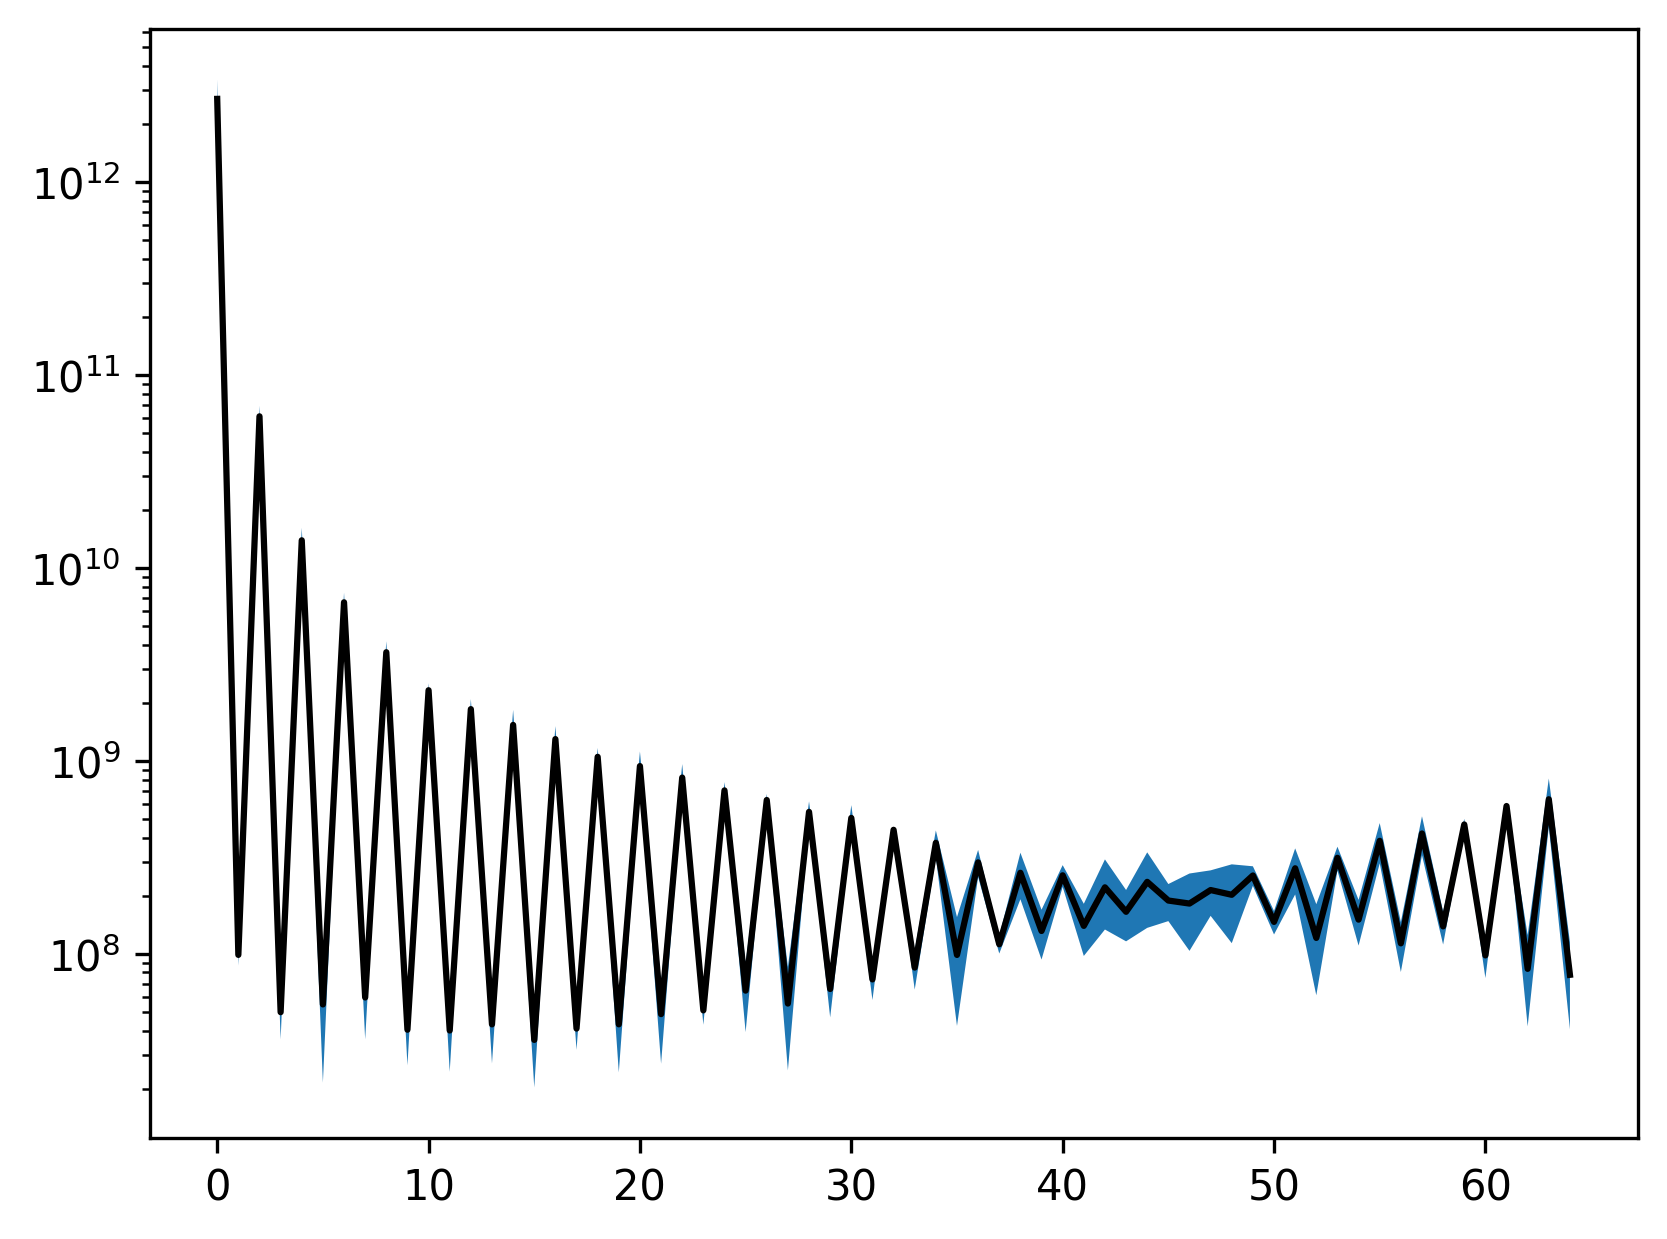

In [73]:
error = 2 * np.std(trace_values_use, 0)
y = np.mean(trace_values_use, 0)

error[error == np.inf] = 0

start, end = 0, 65
y = y[start:end]
error = error[start:end]

x_axis = np.arange(start, end)

plt.plot(x_axis, y, 'k-')
plt.fill_between(x_axis, y - error, y + error)
plt.yscale('log')
# plt.savefig("same_seed")

In [117]:
random_pick = np.random.choice(len(m1_vals_use[0][0]), 5000, replace=False)

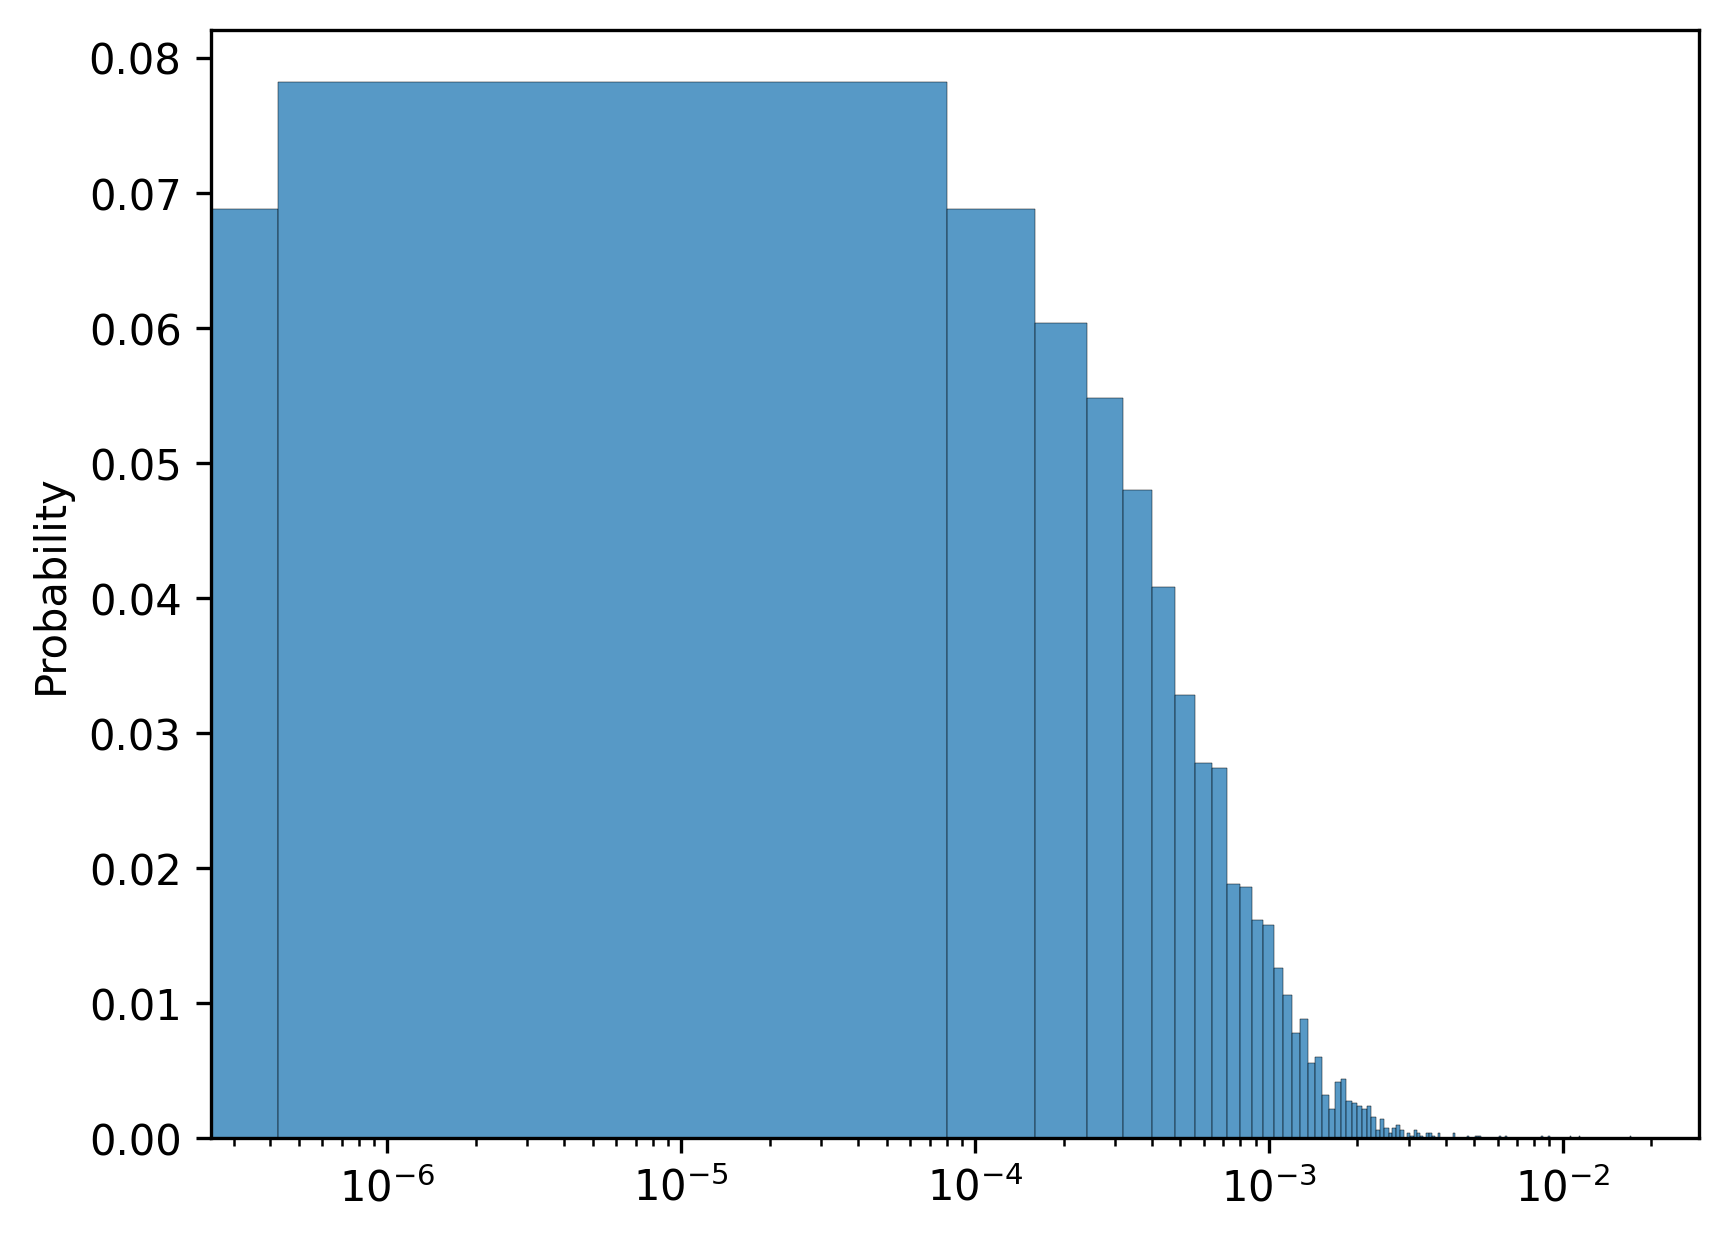

In [121]:
sns.histplot(data=m1_vals_use[0][75][random_pick], stat='probability')
plt.xscale('log')

In [ ]:
ep = 10
plt.hist(m1_vals_use[0][ep][random_pick], bins=100, label="0", alpha=0.75)
plt.hist(m1_vals_use[1][ep][random_pick], bins=100, label="1", alpha=0.75)
plt.hist(m1_vals_use[2][ep][random_pick], bins=100, label="2", alpha=0.75)
plt.hist(m1_vals_use[3][ep][random_pick], bins=100, label="3", alpha=0.75)
plt.legend()

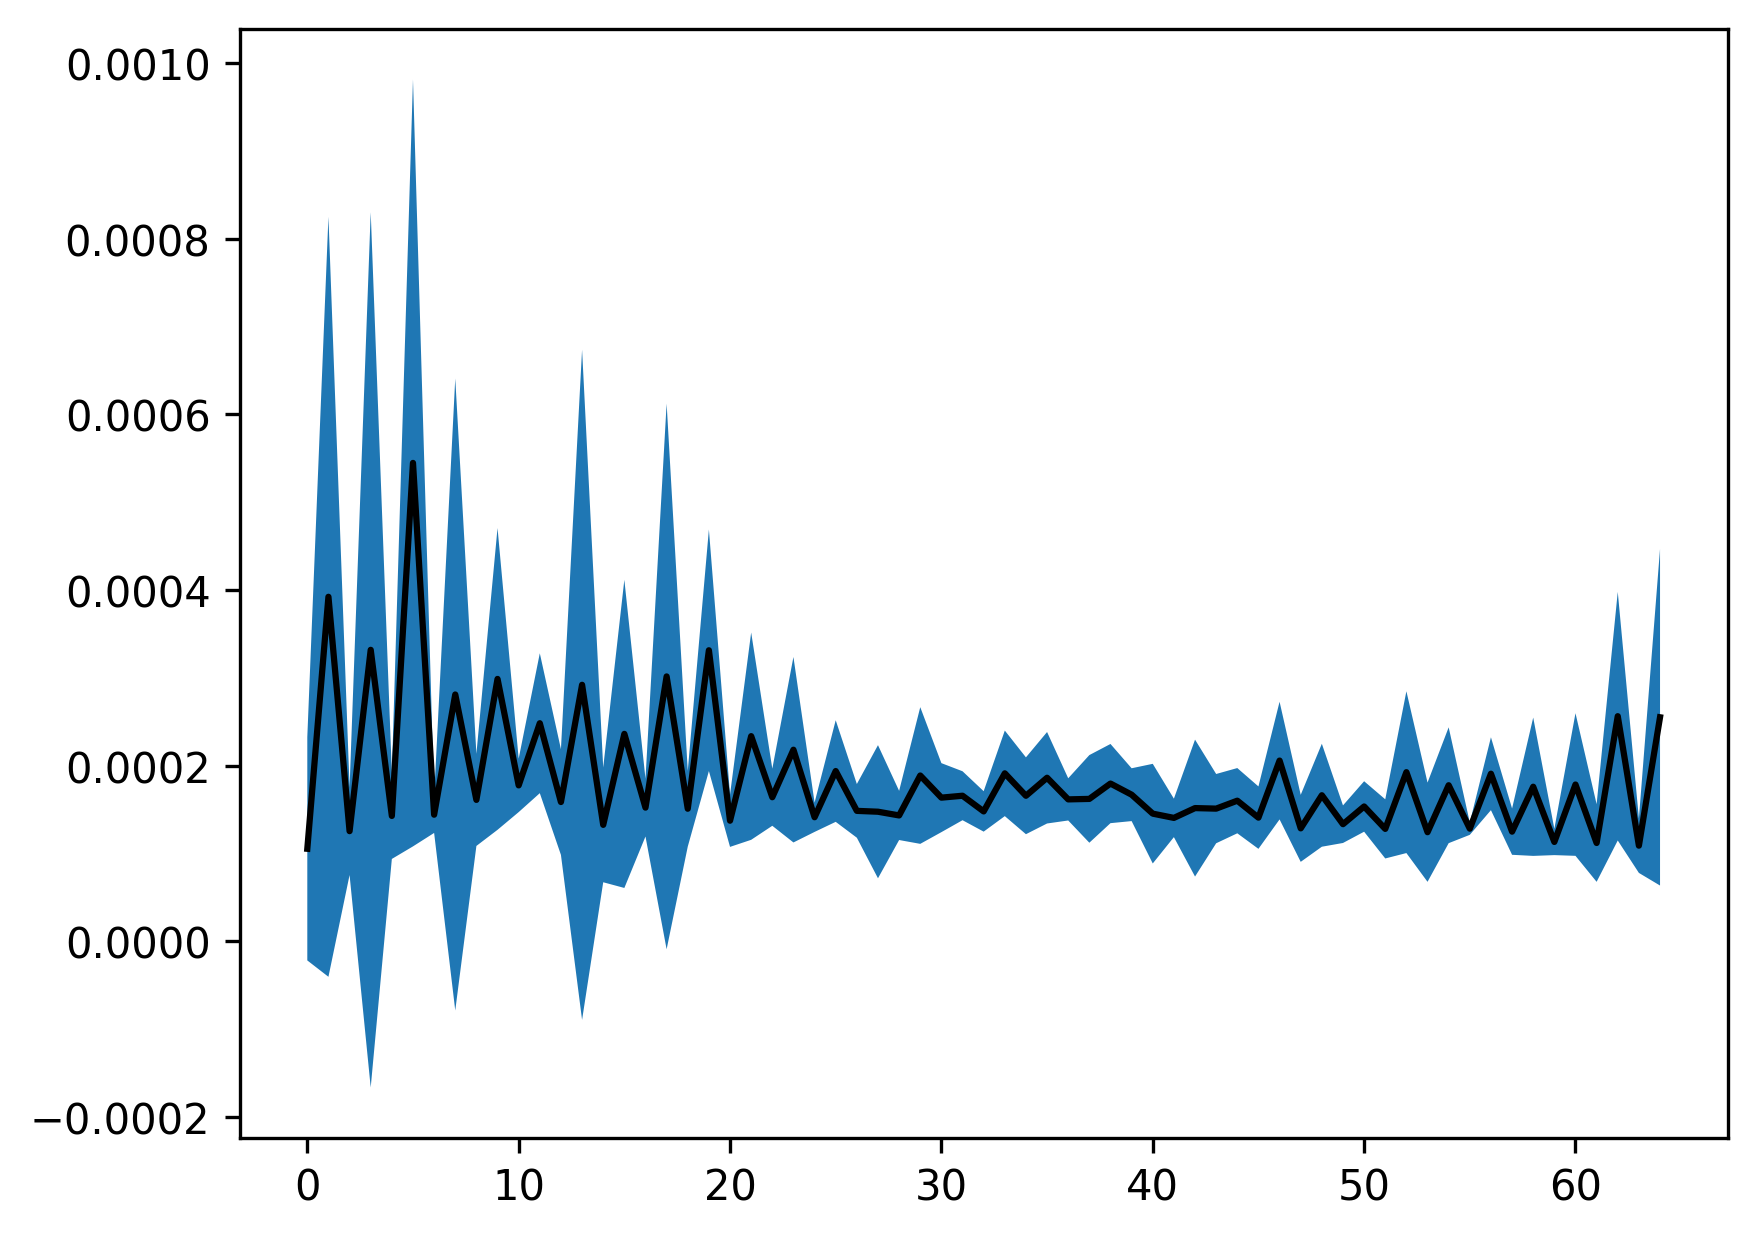

In [80]:
m1_vals_plot = np.mean(m1_vals_use, 2)

error = 2 * np.std(m1_vals_plot, 0)
y = np.mean(m1_vals_plot, 0)

start, end = 0, 65
y = y[start:end]
error = error[start:end]

x_axis = np.arange(start, end)

plt.plot(x_axis, y, 'k-')
plt.fill_between(x_axis, y - error, y + error)
# plt.savefig("same_seed")

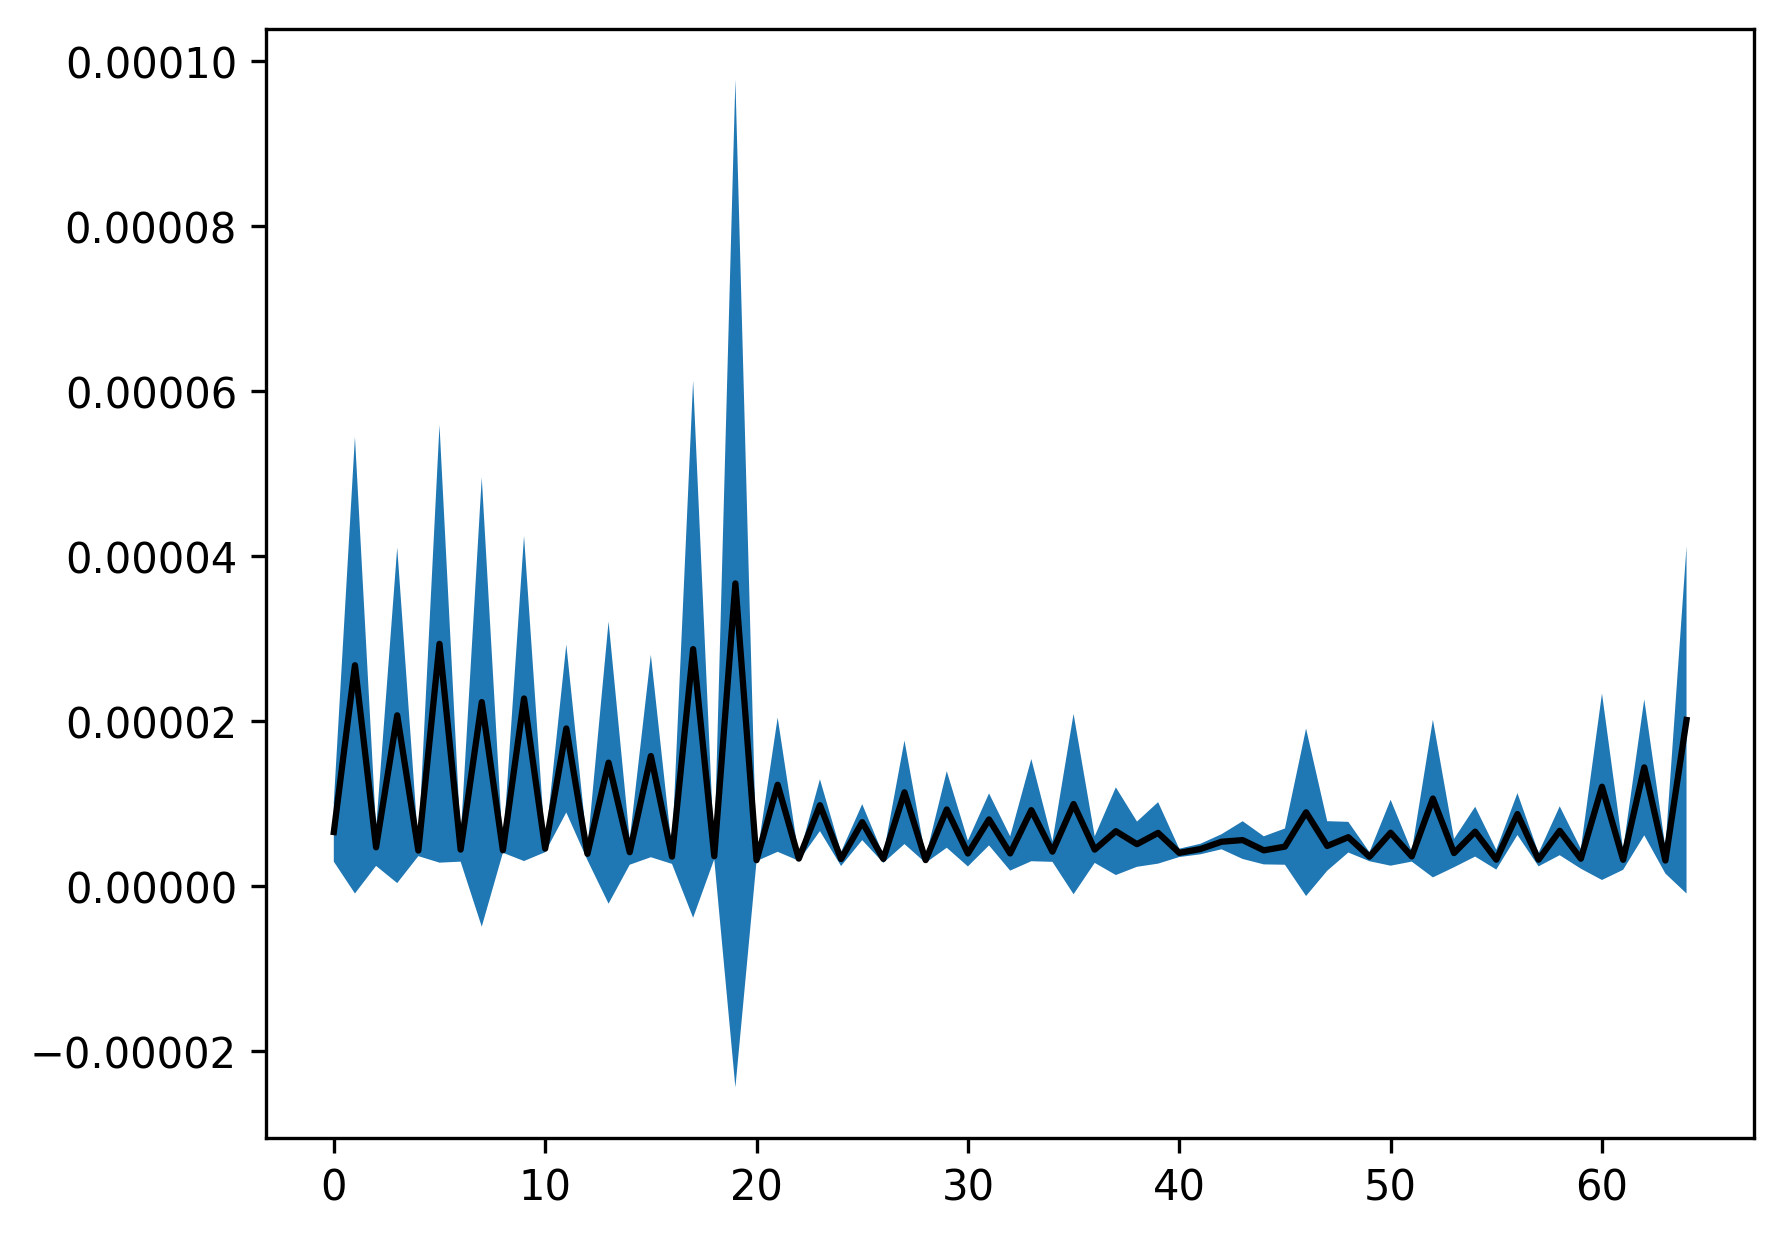

In [81]:
m2_vals_plot = np.mean(m2_vals_use, 2)

error = 2 * np.std(m2_vals_plot, 0)
y = np.mean(m2_vals_plot, 0)

start, end = 0, 65
y = y[start:end]
error = error[start:end]

x_axis = np.arange(start, end)

plt.plot(x_axis, y, 'k-')
plt.fill_between(x_axis, y - error, y + error)
# plt.savefig("same_seed")

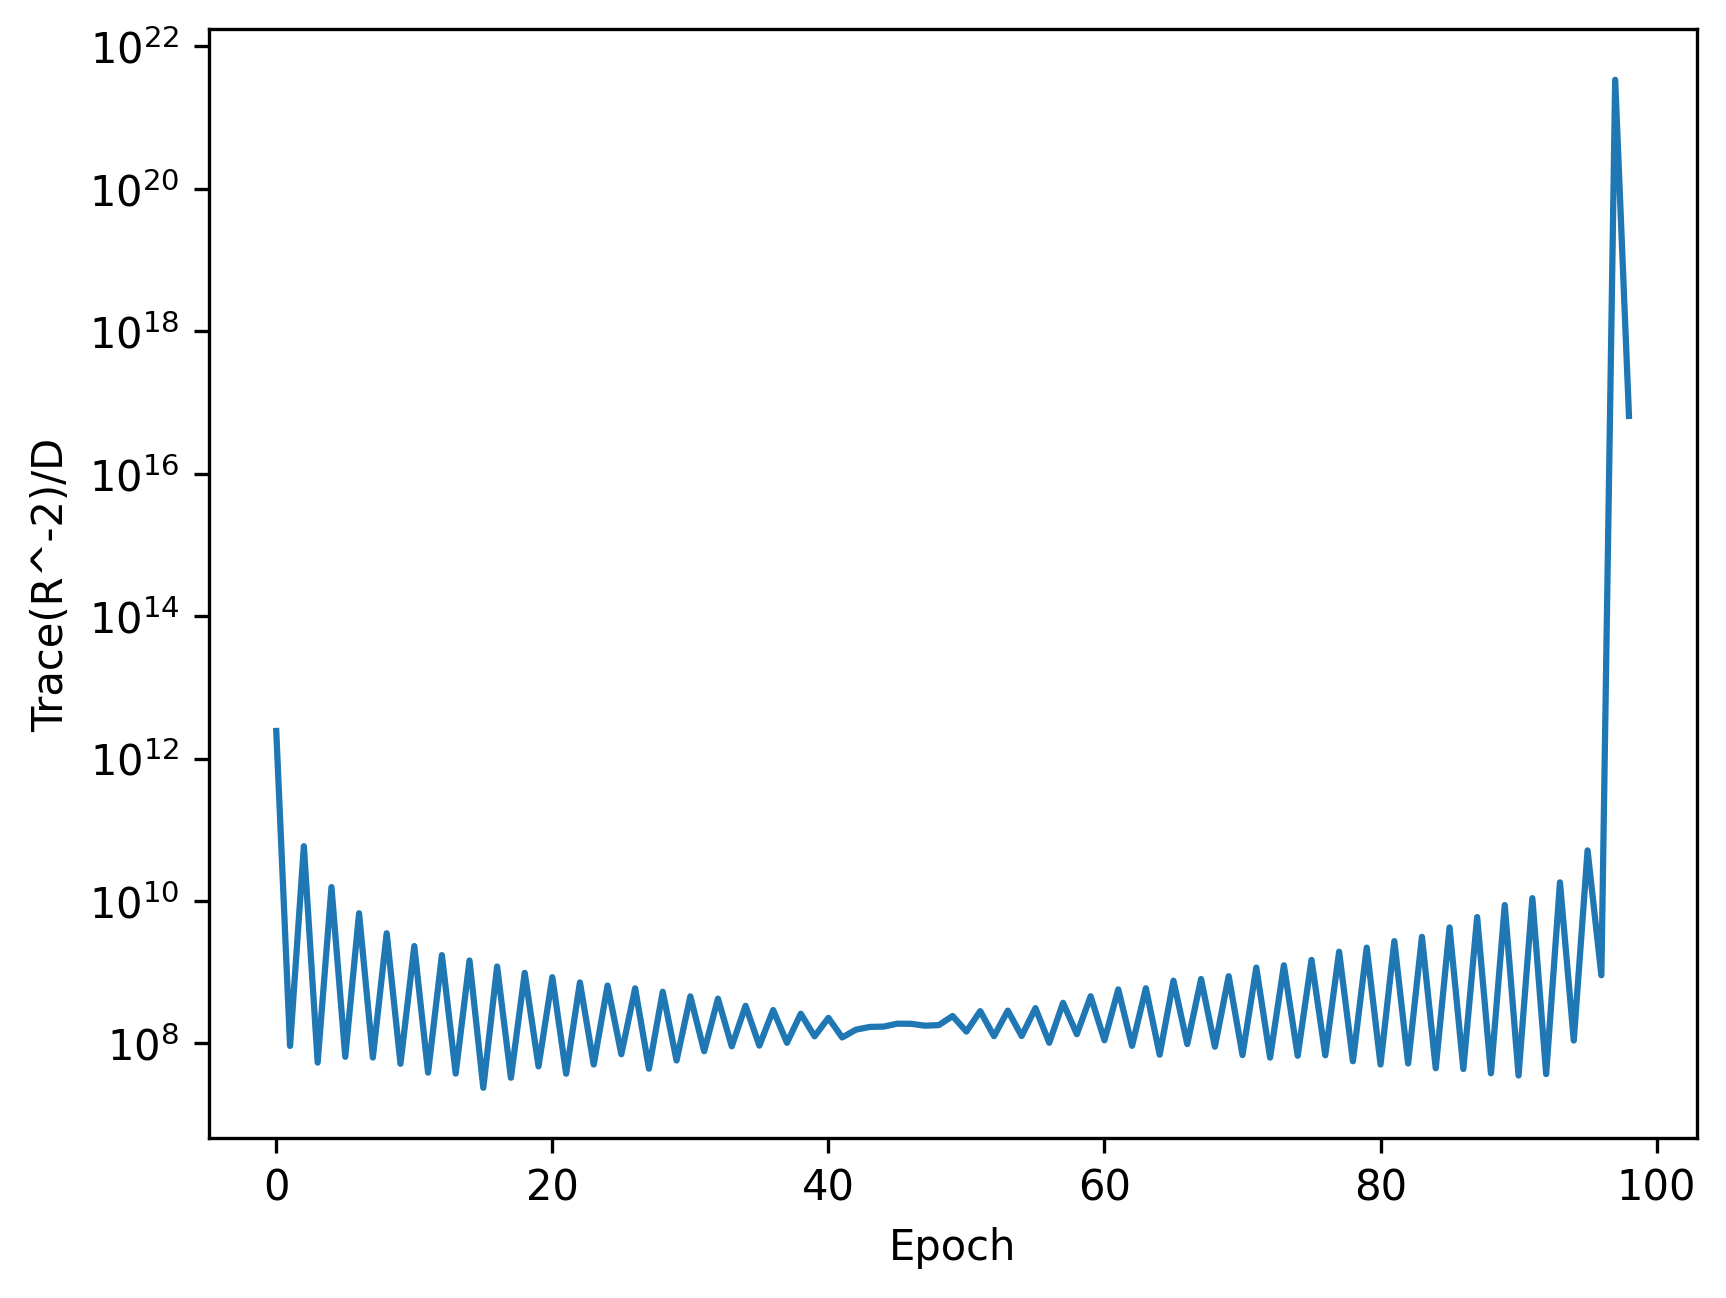

In [27]:
plt.plot(trace_values[3])
plt.ylabel('Trace(R^-2)/D')
plt.xlabel('Epoch')
plt.yscale('log')

In [ ]:
# Pick random 500 parameters
# ordering = np.random.choice(m1_time.shape[1], 500, replace=False)
# Pick based on largest change across training
ordering = np.argsort(np.abs(m1_time[0] - m1_time[-1]))[-500:]
m1_time_vis = m1_time[:, ordering]
print(m1_time_vis.shape)

In [ ]:
m1_time_vis = m1_time

In [ ]:
np.median(m1_time[-1]), np.median(m2_time[-1]) 

In [ ]:
np.mean(m1_time[-1]), np.mean(m2_time[-1]) 

In [ ]:
sns.histplot(data=m1_time[-1], stat='probability')

In [ ]:
sns.histplot(data=m2_time[-1], stat='probability')

In [ ]:
reshaped_data = []

# Loop through each parameter index and time to reshape data
for time in range(m1_time_vis.shape[0]):
    for param_index in range(m1_time_vis.shape[1]):
        reshaped_data.append((time, m1_time_vis[time, param_index]))
    
df = pd.DataFrame(reshaped_data, columns=['Time', 'Value'])

# Plot with seaborn using 'hue' for different parameters
sns.lineplot(data=df, x='Time', y='Value')

plt.show()

In [ ]:
plt.plot(np.sum(m1_time == m2_time, 1))
plt.ylabel('Number of parameters (out of 1469642) where m1[i] = m2[i]')
plt.xlabel('Epoch')

In [ ]:
sns.heatmap(m1_time_vis.T, square=True)
plt.xlim(0, m1_time_vis.shape[0])
plt.ylim(0, m1_time_vis.shape[1])
plt.show()

In [ ]:
# Make an image out of it
np.hist(np.flatten(m1_time_vis))

In [ ]:
m1_time_vis_ = m1_time_vis - np.min(m1_time_vis)
m1_time_vis_ /= np.max(m1_time_vis_)

In [ ]:
plt.hist(np.std(m1_time_vis_, 0))

In [ ]:
plt.plot(m2_time[:, 1])

In [ ]:
import pandas as pd
df = pd.DataFrame(m1_time_vis)

# Melt the DataFrame for seaborn
df_melted = df.reset_index().melt(id_vars='index')

# Plot with seaborn
plt.clf()
sns.lineplot(x='index', y='value', data=df_melted, ci='sd', estimator='mean')
plt.fill_between(df.index, df.mean(axis=1) - 2 * df.std(axis=1), df.mean(axis=1) + 2 * df.std(axis=1), color='blue', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Parameter Value')
plt.show()

In [ ]:
traces = []
for m in models[0]:
    trv, _, _ = compute_trace(m.cuda(), train_loader, test_loader, device="cuda", shift_model=False, get_m1_m2=True)
    traces.append(trv.item())

In [ ]:
np.array(traces) / 1e7

In [ ]:
oye1 = 6104111

In [ ]:
oye2 = 6197758.5

In [ ]:
plt.plot(np.array(trace_values[0])[:60] / 1e7, label="M0")
plt.plot(np.array(trace_values[1])[:60] / 1e7, label="M1")
plt.legend()

In [ ]:
np.array(trace_values[1])[45:55] / 1e7

In [ ]:
np.array(trace_values[0])[45:55] / 1e7

In [ ]:
m1_values = np.array(returned_values[-2])
m2_values = np.array(returned_values[-1])

In [ ]:
for i in range(5):
    sns.histplot(data=m2_values[i], bins=100, color=f'C{i}', stat='probability')

In [ ]:
y = np.mean(m1_values, 1)
plt.plot(np.arange(100), np.mean(m1_values, 1))
error = 2 * np.std(m1_values, 1)
plt.fill_between(np.arange(100), y-error, y+error, alpha=0.3)

In [ ]:
y = np.mean(m2_values, 1)
plt.plot(np.arange(100), np.mean(m2_values, 1))
error = 2 * np.std(m2_values, 1)
plt.fill_between(np.arange(100), y-error, y+error, alpha=0.3)

In [ ]:
test_loader = ch.utils.data.DataLoader(
        ch.utils.data.Subset(test_data, test_index),
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
        worker_init_fn=lambda worker_id: np.random.seed(2024 + worker_id),
    )

In [ ]:
train_loader = ch.utils.data.DataLoader(
        ch.utils.data.Subset(train_data, train_index),
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
        worker_init_fn=lambda worker_id: np.random.seed(2024 + worker_id),
    )

In [ ]:
label_smoothing = 0.15 # 0.1 # 0.01

In [ ]:
m0_loss = collect_loss_values(models[0][0].cuda(), test_loader, label_smoothing=label_smoothing)
m1_loss = collect_loss_values(models[0][1].cuda(), test_loader, label_smoothing=label_smoothing)

In [ ]:
m0_train_loss = collect_loss_values(models[0][0].cuda(), train_loader, label_smoothing=label_smoothing)
m1_train_loss = collect_loss_values(models[0][1].cuda(), train_loader, label_smoothing=label_smoothing)

In [ ]:
# lira = lambda x: np.log(np.exp(-x) / (1 - np.exp(-x)))
# lira = lambda x: -1/(1 + np.exp(0.5-x))
lira = lambda x: -x

In [ ]:
total_labels = np.concatenate(([1] * 1000, [0] * 1000))
fpr, tpr, thresholds = roc_curve(
    total_labels, lira(m0_train_loss[:1000]).tolist() + lira(m0_loss[:1000]).tolist()
)
roc_auc = auc(fpr, tpr)
print(roc_auc)

In [ ]:
0.05 : 0.656559
0.01 : 0.6353175
0.1  : 0.658797

In [ ]:
sns.histplot(data=lira(m0_train_loss), bins=100, color='C0', stat='probability')
sns.histplot(data=lira(m0_loss), bins=100, color='C1', stat='probability')
# plt.xlim(0.35, 0.5)

In [ ]:
lira = lambda x: np.log(np.exp(-x) / (1 - np.exp(-x)))
# lira = lambda x: np.exp(-x)
lira = lambda x: np.exp(-x)
sns.histplot(data=lira(m0_train_loss), bins=100, color='C0', stat='probability')
sns.histplot(data=lira(m0_loss), bins=100, color='C1', stat='probability')
# plt.xlim(0.35, 0.5)

In [ ]:
sns.histplot(data=m0_train_loss, bins=100, color='C0', stat='probability')
sns.histplot(data=m0_loss, bins=100, color='C1', stat='probability')
# plt.xlim(0, 8)

In [ ]:
sns.histplot(data=traces[0] / 1e7 * m0_train_loss, bins=100, color='C0', stat='probability')
sns.histplot(data=traces[0] / 1e7 * m0_loss, bins=100, color='C1', stat='probability')
# plt.xlim(0, 8)

In [ ]:
ordering = np.argsort(m1_loss)
plt.scatter(np.arange(len(m0_loss)), m0_loss[ordering], label="M0", s=4)
plt.scatter(np.arange(len(m0_loss)), m1_loss[ordering], label="M1", s=4)
plt.legend()

In [ ]:
tr_0 = trace_values[0][-1]
tr_1 = trace_values[1][-1]

In [ ]:
tr_0_ = tr_0 / 1e15

In [ ]:
tr_1_ = tr_1 / 1e7

In [ ]:
tr_0_, tr_1_

In [ ]:
ordering = np.argsort(m1_loss)
plt.scatter(np.arange(len(m0_loss)), m0_loss[ordering] * oye1 / 1e7, label="M0", s=4)
plt.scatter(np.arange(len(m0_loss)), m1_loss[ordering] * oye2 / 1e7, label="M1", s=4)
plt.legend()

In [ ]:
ordering = np.argsort(m0_loss)
plt.scatter(np.arange(len(m0_loss)), m0_loss[ordering], label="M0", s=4)
plt.scatter(np.arange(len(m0_loss)), m0_loss[ordering] * oye1 / 1e7, label="M0 (with trace norm)", s=4)
plt.legend()

In [ ]:
ordering = np.argsort(m1_loss)[-100:]
plt.scatter(np.arange(len(ordering)), m1_loss[ordering], label="M1", s=4)
plt.scatter(np.arange(len(ordering)), m1_loss[ordering] * oye2 / 1e7, label="M1 (with trace norm)", s=4)
plt.legend()

In [ ]:
ordering = np.argsort(m0_loss)[-100:]
plt.scatter(np.arange(len(ordering)), m0_loss[ordering] * oye1 / 1e7, label="M0 (with trace norm)", s=4)
plt.scatter(np.arange(len(ordering)), m0_loss[ordering] * oye2 / 1e7, label="M0 (with M1's trace norm)", s=4)
plt.legend()

In [ ]:
m0_loss = m0_loss.numpy()
m1_loss = m1_loss.numpy()

In [ ]:
sns.histplot(data=np.log(m0_loss + 1e-7), bins=100, color='C0', stat='probability', kde=True)
sns.histplot(data=np.log(m1_loss + 1e-7), bins=100, color='C1', stat='probability', kde=True)

In [ ]:
sns.histplot(data=np.log(m0_loss + 1e-7) + np.log(oye1), bins=100, color='C0', stat='probability', kde=True)
sns.histplot(data=np.log(m1_loss + 1e-7) + np.log(oye2), bins=100, color='C1', stat='probability', kde=True)

In [ ]:
ordering = np.argsort(m2_values[0])

time = 0
plt.scatter(np.arange(m2_values.shape[1]), m2_values[time][ordering])
plt.plot()

In [ ]:
y = np.mean(m2_values, 1)
plt.plot(np.arange(100), np.mean(m2_values, 1), color='C1')
error = 2 * np.std(m2_values, 1)
plt.fill_between(np.arange(100), y-error, y+error, alpha=0.3, color='C1')

In [ ]:
diff = np.sum(1/(m2_values - m1_values ** 2), 1)
diff /= m1_values.shape[1]
diff = np.log(diff)
plt.plot(np.arange(100), diff, color='C2')

In [ ]:
tr = np.array([x.item() for x in returned_values[0]])

In [ ]:
tr

In [ ]:
m1 ** 2

In [ ]:
m2

In [ ]:
ch.ones((123, 8)).mean(0).shape

In [ ]:
picked = [0, 1, 2, 3]
epoch = -1

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Loss distributions')

axes_use = [ax1, ax2, ax3, ax4]
for p, ax in zip(picked, axes_use):
    # Get mem/nonmem values
    memv = mem_losses[p][epoch]
    nonmemv = nonmem_losses[p][epoch]
    # Get trace values
    # trace_vals = all_trace_values[p][epoch]
    trace_vals = 0.005
    # Plot distribution scaled with trace values for this model
    ax.hist(np.array(memv) * trace_vals, label=f"in", alpha=0.5, density=True)
    ax.hist(np.array(nonmemv) * trace_vals, label=f"out", alpha=0.5, density=True)

    ax.set_xlim(0, 0.02)
    ax.set_ylim(0, 1000)

axes_use[-1].legend()

In [ ]:
for tv in all_trace_values:
    plt.plot(np.arange(len(tv)), tv)
plt.xlabel("Epoch")
plt.ylabel("Trace value (not scaled by LR)")
plt.title("Trace values for different model initializations")

In [ ]:
time = np.arange(epochs)
D = len(all_m1vals[0][0])

df = pd.DataFrame({
    'Epoch': np.tile(time, len(all_trace_values)),
    'Trace value': np.array(all_trace_values).flatten() / D,
    'Losses': np.array(all_losses).flatten()
})

sns.lineplot(x='Epoch', y='Trace value', data=df)
ax2 = plt.twinx()
sns.lineplot(x='Epoch', y='Losses', data=df, ax=ax2, color='green')
# sns.lineplot(x='Epoch', y='Trace value (not scaled with LR)', data=df)

In [ ]:
picked = np.array(all_trace_values)[:, -50:].flatten()

df = pd.DataFrame(picked, columns=["value"])

fig, ax1 = plt.subplots()
sns.kdeplot(data=df, x="value", ax=ax1, color='red')
ax1.set_xlim((df["value"].min(), df["value"].max()))
ax2 = ax1.twinx()
sns.histplot(data=df, x="value", ax=ax2)

In [ ]:
all_m1vals = np.array(all_m1vals)
all_m2vals = np.array(all_m2vals)

In [ ]:
time = np.arange(epochs)
spicific_param = 42
df = pd.DataFrame({
    'Epoch': np.tile(time, len(all_trace_values)),
    f'm1 ({spicific_param})': all_m1vals[:,:,spicific_param].flatten(),
    f'm2 ({spicific_param})': all_m2vals[:,:,spicific_param].flatten()
})

sns.lineplot(x='Epoch', y=f'm1 ({spicific_param})', data=df)
ax2 = plt.twinx()
sns.lineplot(x='Epoch', y=f'm2 ({spicific_param})', data=df, ax=ax2, color='green')
# sns.lineplot(x='Epoch', y='Trace value (not scaled with LR)', data=df)

In [ ]:
time = np.arange(epochs)
spicific_param = 10000
df = pd.DataFrame({
    'Epoch': np.tile(time, len(all_trace_values)),
    'm1 (mean)': np.mean(all_m1vals, 2).flatten(),
    'm2 (mean)': np.mean(all_m2vals, 2).flatten()
})

sns.lineplot(x='Epoch', y='m1 (mean)', data=df)
ax2 = plt.twinx()
sns.lineplot(x='Epoch', y='m2 (mean)', data=df, ax=ax2, color='green')
# sns.lineplot(x='Epoch', y='Trace value (not scaled with LR)', data=df)

In [ ]:
time = np.arange(epochs)
spicific_param = 10000
df = pd.DataFrame({
    'Epoch': np.tile(time, len(all_trace_values)),
    'm1 (mean)': np.mean(all_m1vals, 2).flatten(),
    'm1 (std)': np.std(all_m1vals, 2).flatten()
})

sns.lineplot(x='Epoch', y='m1 (mean)', data=df)
ax2 = plt.twinx()
sns.lineplot(x='Epoch', y='m1 (std)', data=df, ax=ax2, color='green')
# sns.lineplot(x='Epoch', y='Trace value (not scaled with LR)', data=df)

In [ ]:
plt.hist(np.mean(all_m1vals[:, -50:], 2).flatten(), alpha=0.5, label="m1 (mean)")
plt.hist(np.mean(all_m2vals[:, -50:], 2).flatten(), alpha=0.5, label="m2 (mean)")
plt.legend()

In [ ]:
tr_collection = 1 / (all_m2vals - (all_m1vals ** 2)) * (2 / learning_rate)

In [ ]:
traces = np.sum(tr_collection, 2)
traces /= tr_collection.shape[2]
traces *= 2 / learning_rate

In [ ]:
time = np.arange(traces.shape[1])
df = pd.DataFrame({
    'Epoch': np.tile(time, len(traces)),
    'Tr(R^-2)/D': traces.flatten(),
    'Loss': np.array(all_losses).flatten()
})

g = sns.lineplot(x='Epoch', y='Tr(R^-2)/D', data=df)
g.set_yscale("log")
ax2 = plt.twinx()
sns.lineplot(x='Epoch', y='Loss', data=df, ax=ax2, color='green')

plt.legend(labels=['Tr(R^-2)/D', 'Loss'])

plt.savefig("trace_and_loss.png")